# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [143]:
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [144]:
try:
    data = pd.read_csv('autos.csv')    
except:
    print('Что-то пошло не так...')

In [145]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод:** В предоставленной выборке 354369 строк и 16 столбцов. Все столбцы содержащие числовые данные имеют тип int64. Столбцы с датами представлены в виде строк. Данных для анализа и обучения моделей достаточно. 

### Приведем названия всех столбцов к нижнему регистру

In [147]:
data.columns = data.columns.str.lower()

In [148]:
data = data.rename(columns={
    'vehicletype': 'vehicle_type',
    'registrationyear': 'registration_year',
    'registrationmonth' : 'registration_month',
    'fueltype' : 'fuel_type',
    'datecreated' : 'date_created',
    'numberofpictures' : 'number_of_pictures',
    'postalcode' : 'postal_code',
    'datecrawled' : 'date_crawled',
    'datecreated' : 'date_created',
    'lastseen' : 'last_seen'})

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Удаляем неинформативные столбцы.

In [150]:
data = data.drop(columns = ['date_crawled', 'last_seen', 'number_of_pictures'], axis = 1)

### Изучим пропуски

In [151]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,2), legend = False, fontsize = 16)
            .set_title('Количество пропусков в столбцах, %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

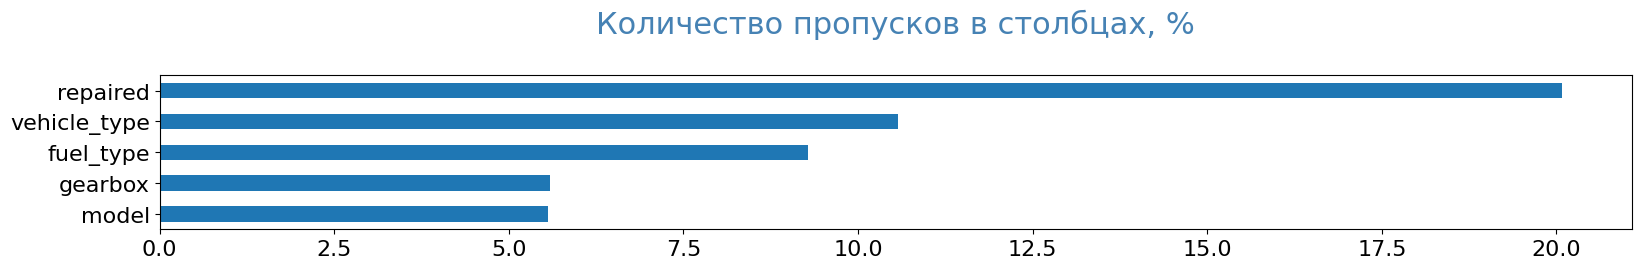

In [152]:
pass_value_barh(data)

В 20% анкет не указано, была ли машина в ремонте и модель авто. Введем третью категорию "unknown" и заменим на нее пропуски в столбце repaired и model

In [153]:
data.repaired = data.repaired.fillna('unknown')

In [154]:
data.model = data.model.fillna('unknown')

В 10% анкет не указан тип кузова. Заменим эти пропуски на самые популярные варианты из анкет с автомобилями аналогичного бренда и модели.

In [155]:
data['vehicle_type'] = data.groupby(['brand', 'model'])['vehicle_type'].transform((
    lambda x: x.fillna(x.mode()[0] if x.count() != 0 else "unknown")))

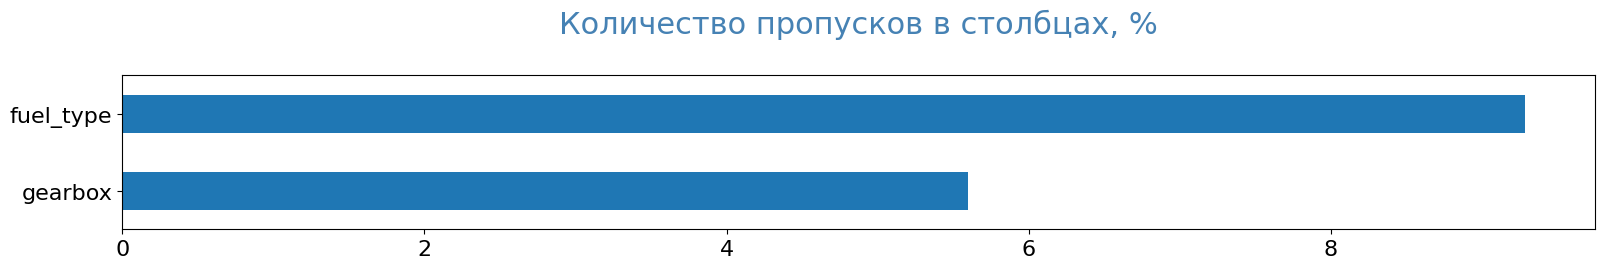

In [157]:
pass_value_barh(data)

Поступим также с пропусками в столбцах fuel_type и gearbox:

In [158]:
data['fuel_type'] = data.groupby(['brand', 'model'])['fuel_type'].transform((
    lambda x: x.fillna(x.mode()[0] if x.count() != 0 else "unknown")))

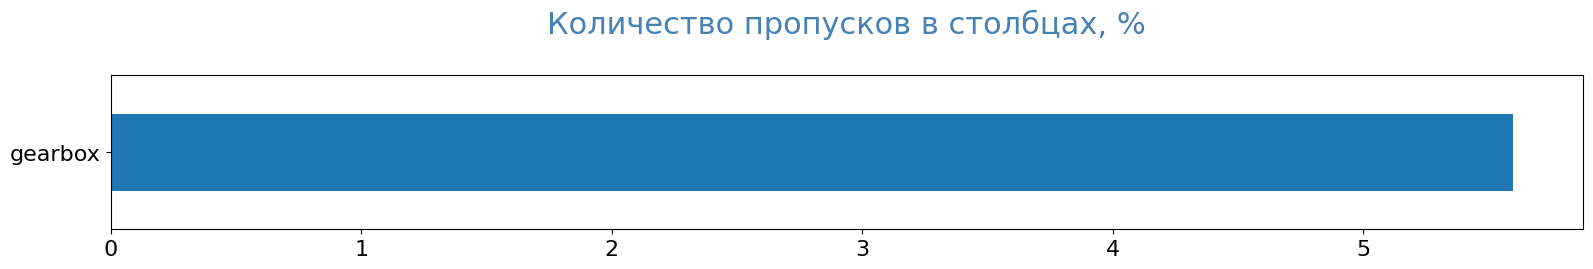

In [160]:
pass_value_barh(data)

In [161]:
data['gearbox'] = data.groupby(['brand', 'model'])['gearbox'].transform((
    lambda x: x.fillna(x.mode()[0] if x.count() != 0 else "unknown")))

In [163]:
data.isna().sum().sum()

0

### Изучим и удалим аномалии в столбцах

#### price

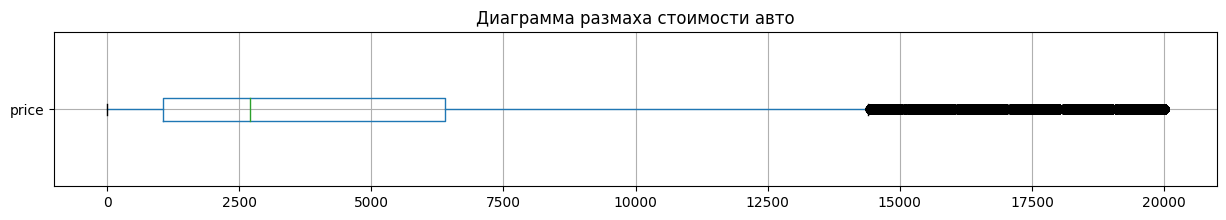

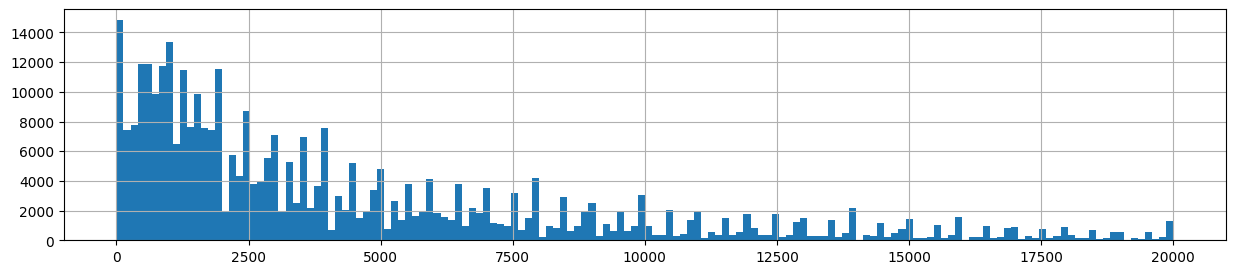

In [164]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха стоимости авто')
plt.show()
data['price'].hist(bins = 150, figsize = (15,3));

In [165]:
data.query('price==0').shape[0]

10772

В 10772 анкетах указана нулевая стоимость авто. Удаляем эти объекты, они снизят точность предсказаний. 

In [166]:
data = data.query('price!=0')

In [167]:
data.shape

(343597, 13)

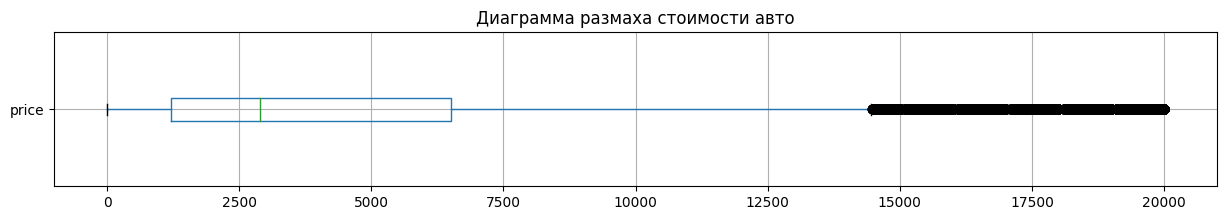

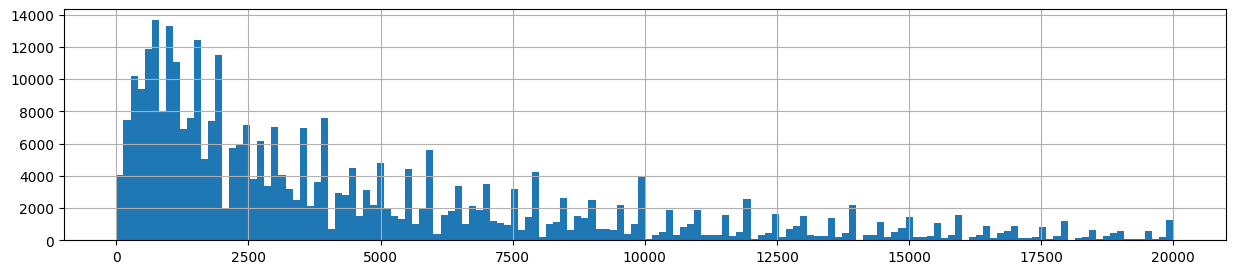

In [168]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха стоимости авто')
plt.show()
data['price'].hist(bins = 150, figsize = (15,3));

Остальные значения оставим без изменений.

#### registration_year

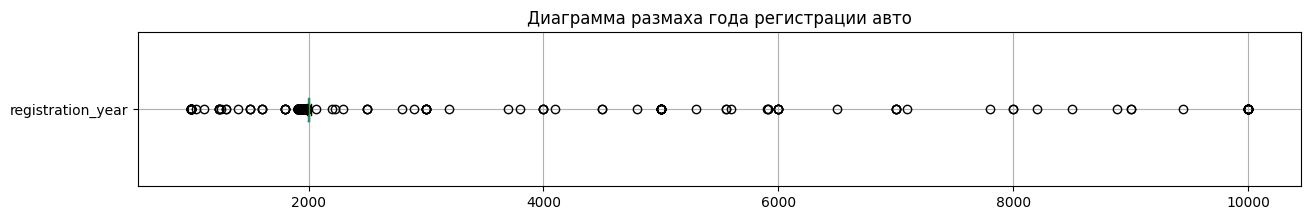

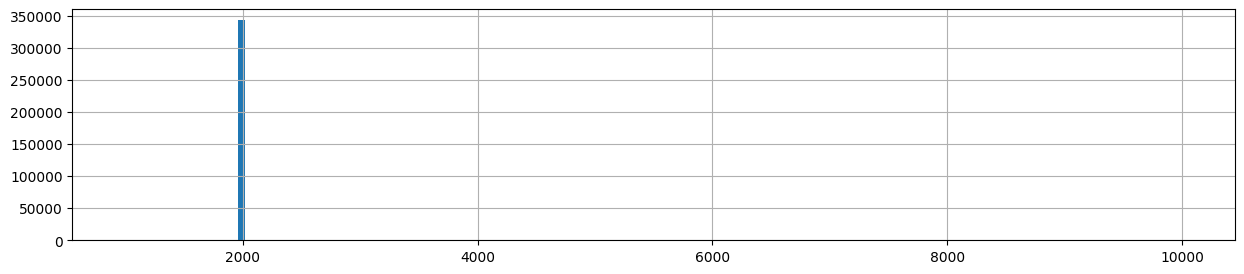

In [169]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['registration_year']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха года регистрации авто')
plt.show()
data['registration_year'].hist(bins = 150, figsize = (15,3));

У части объектов указаны нереальные даты. Удалаяем, т.к их количество незначительно.

In [170]:
data = data.query('1900<=registration_year<=2016')

In [171]:
data.shape

(329765, 13)

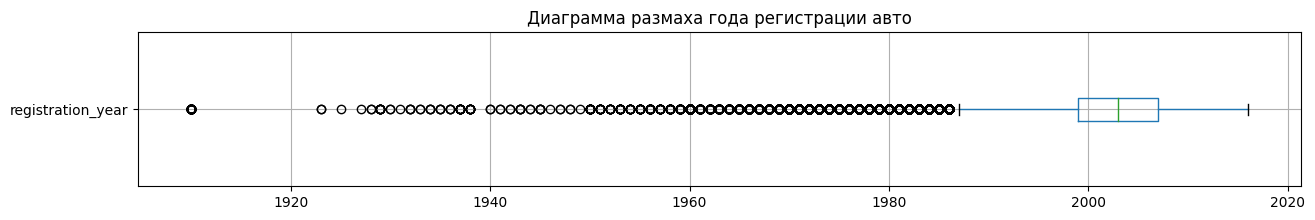

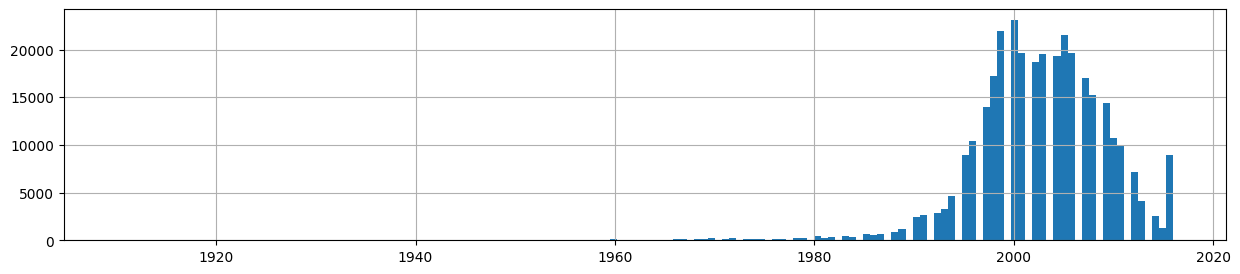

In [172]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['registration_year']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха года регистрации авто')
plt.show()
data['registration_year'].hist(bins = 150, figsize = (15,3));

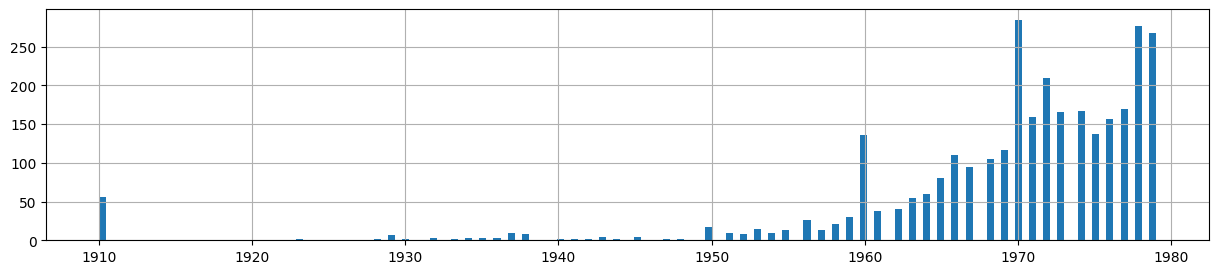

In [173]:
data.query('registration_year<1980')['registration_year'].hist(bins = 150, figsize = (15,3));

In [174]:
data.query('registration_year<1950').shape[0]

126

Удаляем объекты до 1950 года. Их всего 126.

In [175]:
data = data.query('registration_year>=1950')

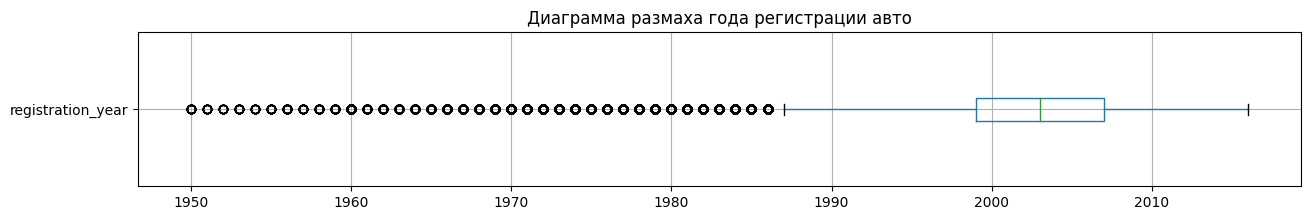

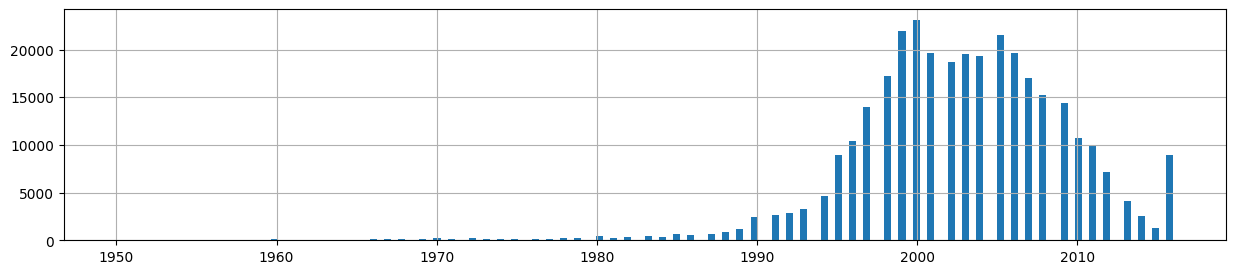

In [176]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['registration_year']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха года регистрации авто')
plt.show()
data['registration_year'].hist(bins = 150, figsize = (15,3));

#### power

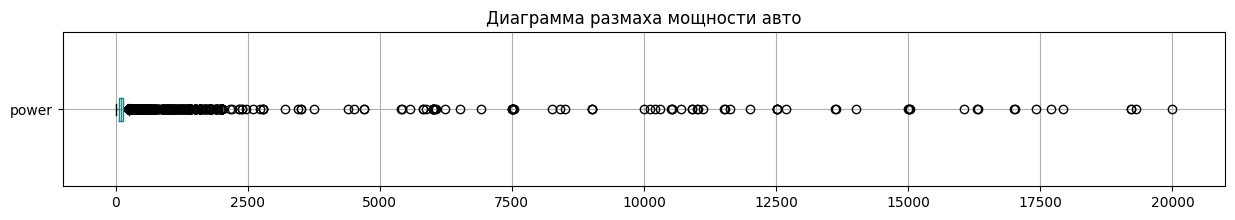

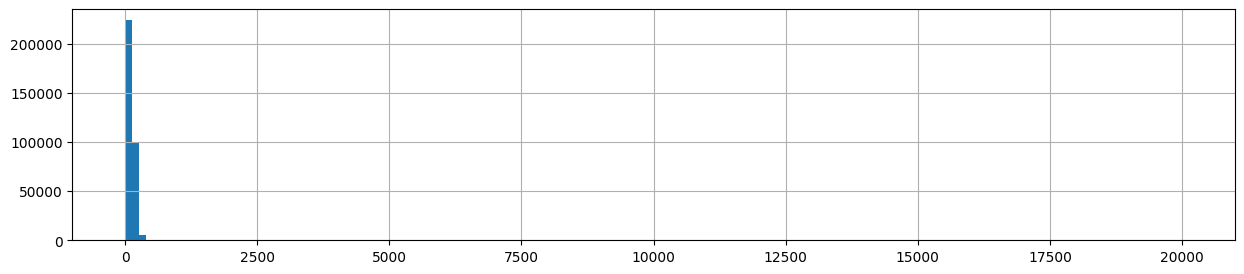

In [177]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха мощности авто')
plt.show()
data['power'].hist(bins = 150, figsize = (15,3));

In [178]:
data.query('power>=1500').shape

(177, 13)

Самый мощный серийный автомобиль в мире имеет мощность двигателя 1500 л.с. Сразу удаляем все объекты с мощностью выше, их всего 189.

In [179]:
data = data.query('power<1500')

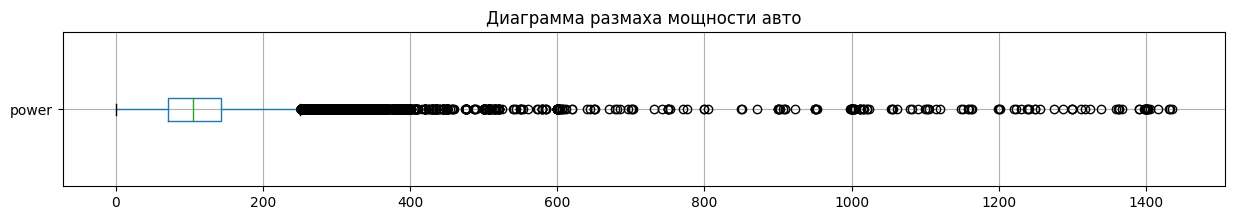

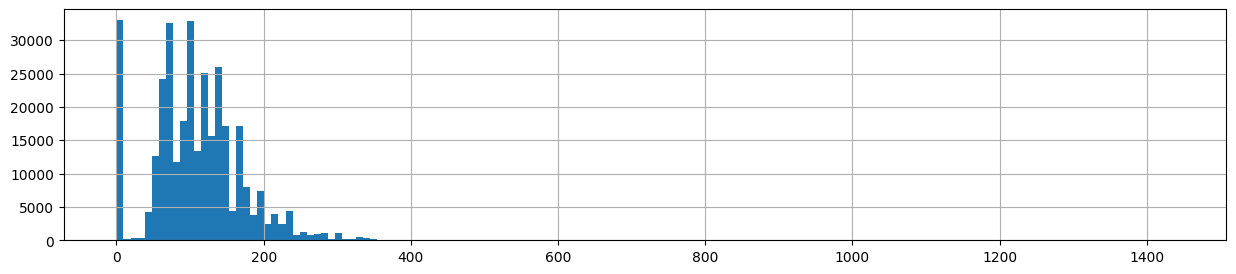

In [180]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха мощности авто')
plt.show()
data['power'].hist(bins = 150, figsize = (15,3));

Приблизим гистограмму.

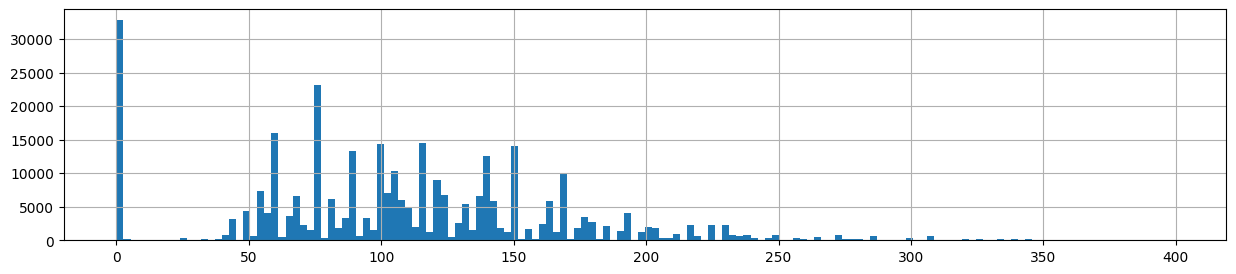

In [181]:
data.query('power<400')['power'].hist(bins = 150, figsize = (15,3));

In [182]:
data.query('power>350').shape[0]

923

Удаляем объекты с мощность авто выше 350. Их 953.

In [183]:
data = data.query('power<=350')

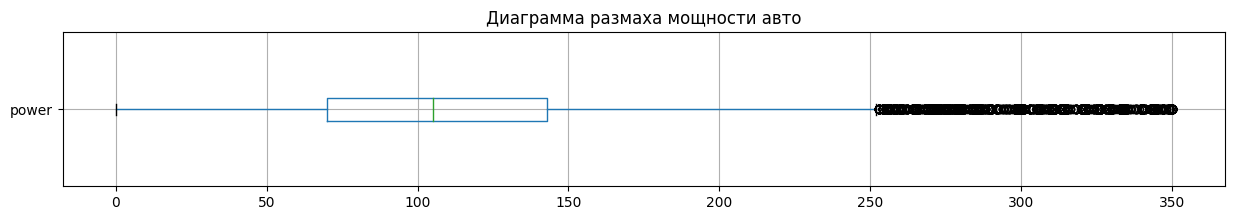

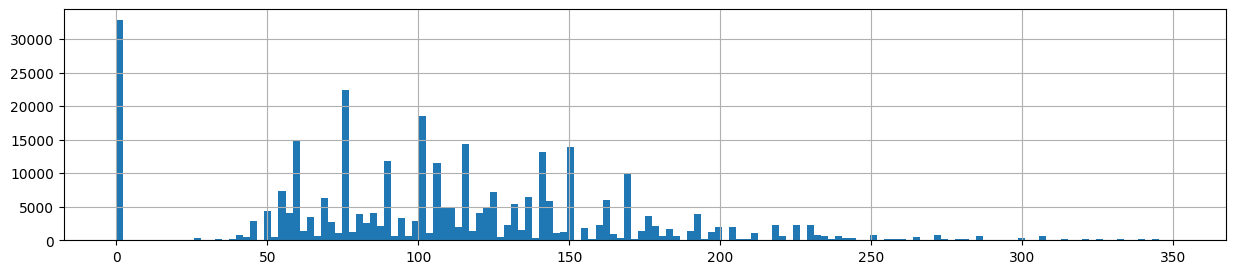

In [184]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха мощности авто')
plt.show()
data['power'].hist(bins = 150, figsize = (15,3));

In [185]:
data.query('power==0').shape[0]

32787

У 36180 объектов указана нулевая мощность двигателя. Это может сильно снизить точность моделей. Заменем нули на среднюю мощность автомобилей аналогичного бренда, модели и коробки передач. 

In [186]:
data.loc[data['power']==0, 'power'] = None #заменим все 0 в power на None для корректного посчета среднего значения

In [187]:
#создадим новый столбец со средними значениями power
data['1'] = (
    data[['brand', 'model', 'gearbox', 'power']]    
    .groupby(['brand', 'model', 'gearbox'])
    .power
    .transform('mean')
)

In [188]:
#заменим пропуски на соответствующие средние значения 
data.loc[data['power'].isna(), 'power'] = data.loc[data['power'].isna(), '1']
data.power.isna().sum()

2

Остался 21 объект. Это те объявления, для которых мы не смогли в нашей выборке найти аналогичные авто с указанной мощностью двигателя. Удаляем эти объекты и созданный нами столбец.

In [189]:
data = data.drop('1', axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328537 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               328537 non-null  int64  
 1   vehicle_type        328537 non-null  object 
 2   registration_year   328537 non-null  int64  
 3   gearbox             328537 non-null  object 
 4   power               328537 non-null  float64
 5   model               328537 non-null  object 
 6   kilometer           328537 non-null  int64  
 7   registration_month  328537 non-null  int64  
 8   fuel_type           328537 non-null  object 
 9   brand               328537 non-null  object 
 10  repaired            328537 non-null  object 
 11  date_created        328537 non-null  object 
 12  postal_code         328537 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 35.1+ MB


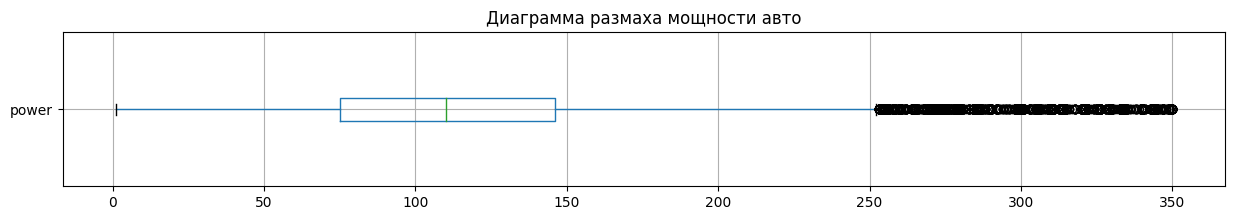

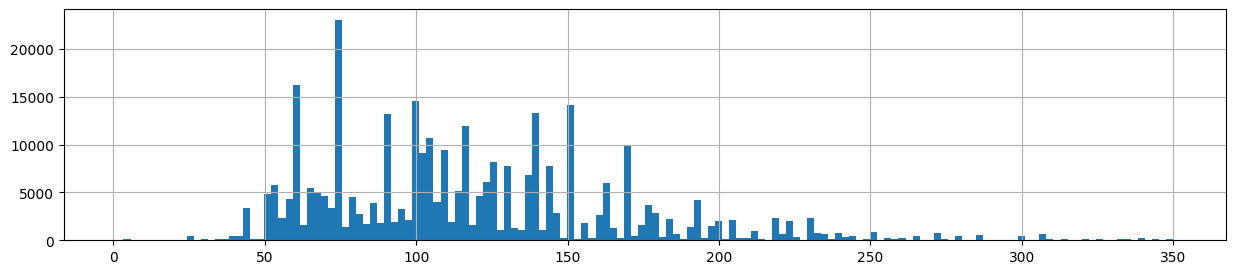

In [190]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха мощности авто')
plt.show()
data['power'].hist(bins = 150, figsize = (15,3));

#### kilometer

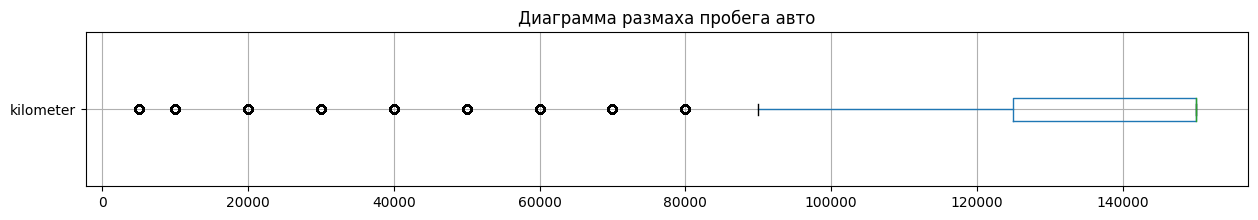

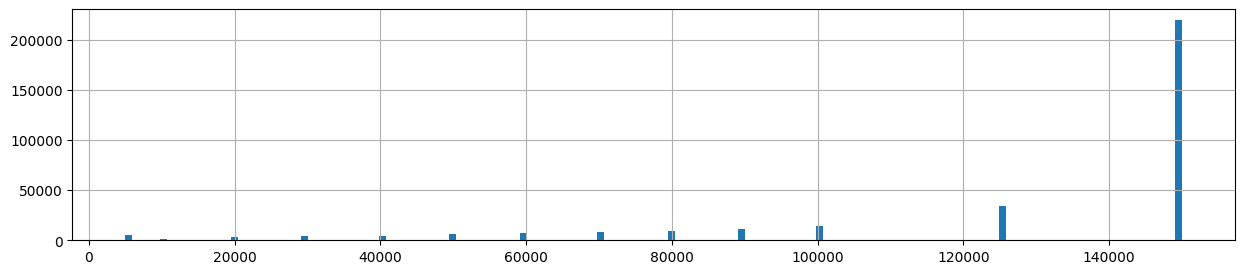

In [191]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['kilometer']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха пробега авто')
plt.show()
data['kilometer'].hist(bins = 150, figsize = (15,3));

В основном в нашей выборке автомобили с пробегом от 90 т.км до 150 тыс.км. 

#### registration_month

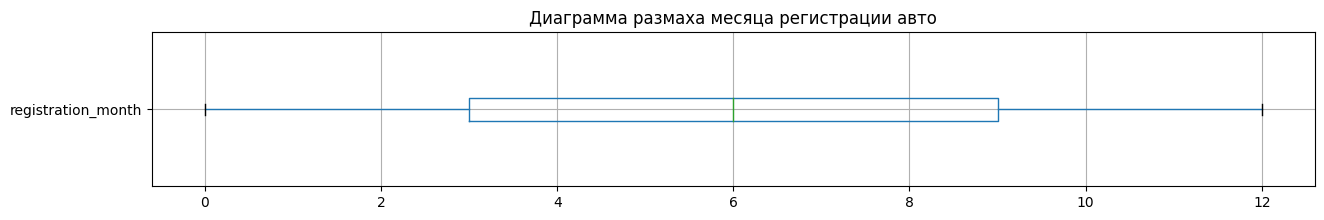

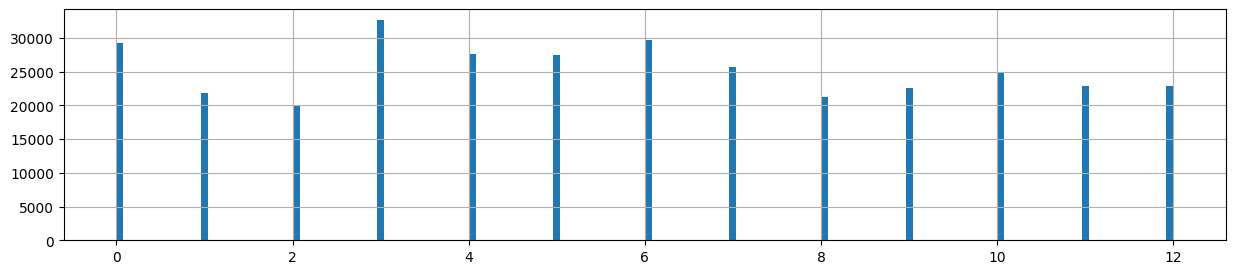

In [192]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['registration_month']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха месяца регистрации авто')
plt.show()
data['registration_month'].hist(bins = 150, figsize = (15,3));

registration_month это категориальный признак. Нулевого месяца конечно не существует, но мы рассматриваем это как категорию unknown. Оставим без изменений.

#### postal_code

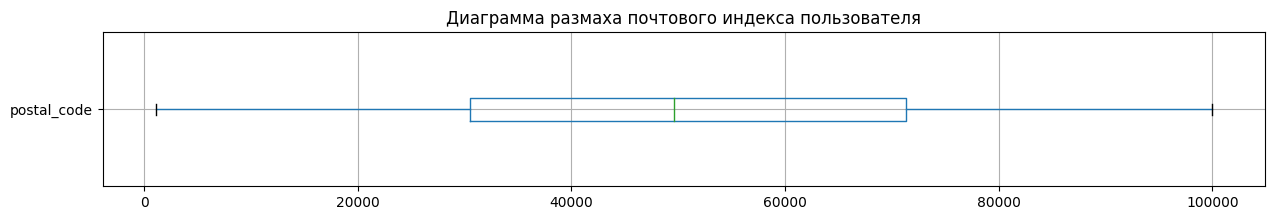

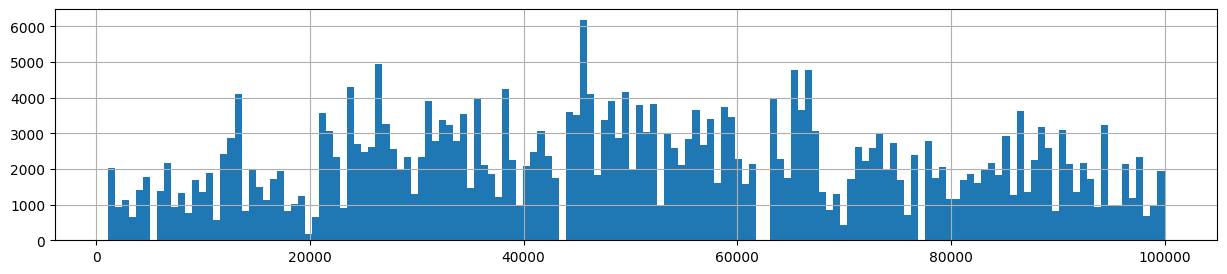

In [193]:
fig, ax = plt.subplots(figsize = (15,2))
ax = data[['postal_code']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха почтового индекса пользователя')
plt.show()
data['postal_code'].hist(bins = 150, figsize = (15,3));

In [194]:
data.postal_code.nunique()

8133

Почтовый индекс это категориальный признак. На 340 тыс объектов 8 тыс уникальных значений категориального признака. Это слишком много.

In [195]:
data = data.drop('postal_code', axis=1)

#### date_created

Разобьем дату создания объявления на три категориальных признака: день недели, месяц и год.

In [196]:
data['date_created'].head()

0    2016-03-24 00:00:00
1    2016-03-24 00:00:00
2    2016-03-14 00:00:00
3    2016-03-17 00:00:00
4    2016-03-31 00:00:00
Name: date_created, dtype: object

In [197]:
data['date_created'] = pd.to_datetime(
    data['date_created'],
    format='%Y-%m-%d %H:%M:%S'
)
data['date_created'].head()

0   2016-03-24
1   2016-03-24
2   2016-03-14
3   2016-03-17
4   2016-03-31
Name: date_created, dtype: datetime64[ns]

In [198]:
data['weekday'] = data['date_created'].dt.weekday
data['month'] = data['date_created'].dt.month
data['year'] = data['date_created'].dt.year

In [199]:
data = data.drop('date_created', axis=1)

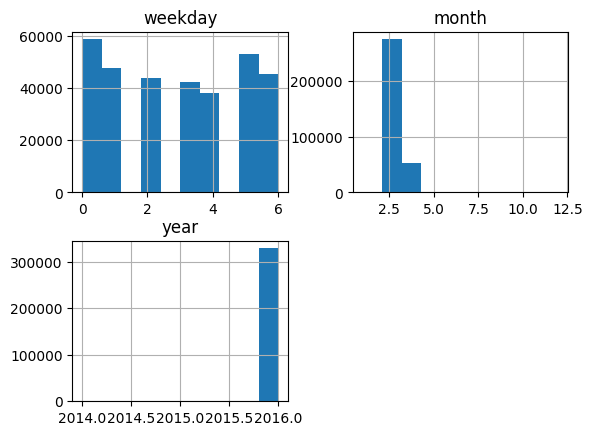

In [200]:
data[['weekday', 'month', 'year']].hist();

In [201]:
data.year.value_counts()

2016    328511
2015        25
2014         1
Name: year, dtype: int64

In [202]:
data.month.value_counts()

3     275101
4      52969
2        379
1         64
11         9
12         9
9          3
8          2
6          1
Name: month, dtype: int64

In [203]:
data = data.drop(['month', 'year'], axis=1)

Изменим тип данных в столбце power, чтобы уменьшить количество категорий.

In [204]:
data.power = data.power.round(0).astype('int')
data.power.head()

0    101
1    190
2    163
3     75
4     69
Name: power, dtype: int32

### Проверим неявные дубликаты в признаках со строковыми значениями

In [205]:
data.vehicle_type.unique()

array(['sedan', 'coupe', 'suv', 'small', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [206]:
data.gearbox.unique()

array(['manual', 'auto'], dtype=object)

In [207]:
sorted(data.model.unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [208]:
data.fuel_type.unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [209]:
sorted(data.brand.unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

In [210]:
data.repaired.unique()

array(['unknown', 'yes', 'no'], dtype=object)

Неявных дубликатов в признаках со строковыми значениями нет.

### Проверим на дубликаты в целом

In [211]:
data.duplicated().sum()

13570

In [212]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Удалено 11547 явных дубликатов

**Вывод:** Удалены неинформативные столбцы 'date_crawled', 'last_seen', 'number_of_pictures'.\
В 5 столбцах были обноружены пропуски в данных.\
В 20% анкет не указано, была ли машина в ремонте. Ввели третью категорию "unknown" и заменим на нее пропуски в столбце repaired.\
В 10% анкет не указан тип кузова. Заменили эти пропуски на самые популярные варианты из анкет с автомобилями аналогичного бренда и модели.\
Поступили также с пропусками в столбцах fuel_type и gearbox.\
Оставшиеся пропуски заменили на категорию "unknown".

В 10772 анкетах указана нулевая стоимость авто. Удалили эти объекты.\
Удалили объекты с даой регистрации авто до 1950года и после 2023.\
Удалили объекты с мощность авто выше 350 л.с. У 36180 объектов была указана нулевая мощность двигателя. Заменили нули на среднюю мощность автомобилей аналогичного бренда, модели и с аналогичной коробкой передач.\
Разбили дату создания объявления на три категориальных признака: день недели, месяц и год.\
Неявных дубликатов в признаках со строковыми значениями нет.\
Удалено 11547 явных дубликатов

## Обучение моделей

### Подготовим выборку для обучения моделей.

In [213]:
features = data.drop('price', axis=1)
target = data['price']

In [214]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=.6, random_state=12345)

In [215]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, train_size=.5, random_state=12345)

In [216]:
cat_features = [ 'vehicle_type',
                 'registration_year',
                 'gearbox',                                
                 'model',                                
                 'registration_month',
                 'fuel_type',
                 'brand',
                 'repaired',                 
                 'weekday']

In [217]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore', drop='first'),
                                        cat_features),
                                      (StandardScaler(), ['power', 'kilometer']),
                                      remainder='passthrough')

In [218]:
data.nunique()

price                 3687
vehicle_type             8
registration_year       67
gearbox                  2
power                  343
model                  250
kilometer               13
registration_month      13
fuel_type                7
brand                   40
repaired                 3
weekday                  7
dtype: int64

### Модель Случайный лес

In [219]:
%%time
model_forest = RandomForestRegressor(random_state=12345, n_estimators=10)
pipe = make_pipeline(column_trans, model_forest)
param_grid = {'randomforestregressor__max_depth': range(2, 8, 2),              
              'randomforestregressor__min_samples_split': (2, 3, 4),
              'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
             }
model_forest_r = RandomizedSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    random_state=12345)
model_forest_r.fit(features_train, target_train)

CPU times: total: 12.2 s
Wall time: 46 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['vehicle_type',
                                                                                'registration_year',
                                                                                'gearbox',
                                                                                'model',
                                                                                'registration_month',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired',
                                                                                'weekday']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['power',
                                                                                'kilometer'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_estimators=10,
                                                                    random_state=12345))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(2, 8, 2),
                                        'randomforestregressor__min_samples_leaf': (1,
                                                                                    2,
                                                                                    3,
                                                                                    4),
                                        'randomforestregressor__min_samples_split': (2,
                                                                                     3,
                                                                                     4)},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [220]:
print(model_forest_r.best_params_)
print(model_forest_r.best_score_)

{'randomforestregressor__min_samples_split': 3, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 6}
-2800.7389800771944


In [221]:
%%time
model_forest = RandomForestRegressor(
    random_state=12345,
    n_estimators=100,
    min_samples_split=3,
    min_samples_leaf=3,
    max_depth=6)
pipe.fit(features_train, target_train)

CPU times: total: 6min 42s
Wall time: 6min 42s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'registration_month',
                                                   'fuel_type', 'brand',
                                                   'repaired', 'weekday']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['power', 'kilometer'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10, random_state=12345))])

In [222]:
%%time
prediction = pipe.predict(features_valid)

C:\123\WPy64-31090\python-3.10.9.amd64\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 375 ms
Wall time: 375 ms


In [223]:
mean_squared_error(target_valid, prediction, squared = False)

1793.3391993747325

**Модель RandomForestRegressor**

Время обучения 397s\
Время предсказания 363ms\
Качество предсказания по метрике RMSE: 1793

### Модель LightGBM

In [224]:
model = lgb.LGBMRegressor(metric='root_mean_squared_error')
pipe = make_pipeline(column_trans, model)
param_grid = {'lgbmregressor__max_depth': range(2, 12, 2),              
              'lgbmregressor__learning_rate': np.arange(.1, .9, .1),
              'lgbmregressor__n_estimators': range(100, 1000, 100)
             }
model_lgbm_r = RandomizedSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    random_state=12345)
model_lgbm_r.fit(features_train, target_train)
print(model_lgbm_r.best_params_)
print(model_lgbm_r.best_score_)

{'lgbmregressor__n_estimators': 500, 'lgbmregressor__max_depth': 10, 'lgbmregressor__learning_rate': 0.2}
-1653.984398231191


In [225]:
%%time
model = lgb.LGBMRegressor(metric='root_mean_squared_error', n_estimators=500, max_depth=10, learning_rate=0.2)
pipe_lgbm = make_pipeline(column_trans, model)
pipe_lgbm.fit(features_train, target_train)

CPU times: total: 17.5 s
Wall time: 1.9 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'registration_month',
                                                   'fuel_type', 'brand',
                                                   'repaired', 'weekday']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['power', 'kilometer'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.2, max_depth=10,
                               metric='root_mean_squared_error',
                               n_estimators=500))])

In [226]:
%%time
prediction = pipe_lgbm.predict(features_valid)

C:\123\WPy64-31090\python-3.10.9.amd64\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 3.08 s
Wall time: 372 ms


In [227]:
mean_squared_error(target_valid, prediction, squared = False)

1643.3544470602767

**Модель LightGBM**

Время обучения 1.86s\
Время предсказания 239ms\
Качество предсказания по метрике RMSE: 1643

### Модель CatBoost

In [228]:
model = CatBoostRegressor(loss_function="RMSE", verbose=False)
pipe = make_pipeline(column_trans, model)
param_grid = {'catboostregressor__depth': range(2, 12, 2),              
              'catboostregressor__learning_rate': np.arange(.1, .9, .1),
              'catboostregressor__iterations': range(100, 1000, 100)
             }
model_cat_r = RandomizedSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1,
    random_state=12345)
model_cat_r.fit(features_train, target_train)
print(model_cat_r.best_params_)
print(model_cat_r.best_score_)

{'catboostregressor__learning_rate': 0.4, 'catboostregressor__iterations': 400, 'catboostregressor__depth': 8}
-1654.2437883727864


In [229]:
%%time
model = CatBoostRegressor(loss_function="RMSE", verbose=False, depth=8, learning_rate=0.4, iterations=400)
pipe_cat = make_pipeline(column_trans, model)
pipe_cat.fit(features_train, target_train)

CPU times: total: 1min 4s
Wall time: 8.73 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['vehicle_type',
                                                   'registration_year',
                                                   'gearbox', 'model',
                                                   'registration_month',
                                                   'fuel_type', 'brand',
                                                   'repaired', 'weekday']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['power', 'kilometer'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x00000204CFF162F0>)])

In [230]:
%%time
prediction = pipe_cat.predict(features_valid)

CPU times: total: 844 ms
Wall time: 258 ms


C:\123\WPy64-31090\python-3.10.9.amd64\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [231]:
mean_squared_error(target_valid, prediction, squared = False)

1643.411853535948

**МодельCatBoost**

Время обучения 8.6s\
Время предсказания 252ms\
Качество предсказания по метрике RMSE: 1643

## Анализ моделей

In [232]:
pd.DataFrame([['397s', '1.86s', '8.6s'], ['363ms', '239ms', '252ms'], [1793, 1643, 1643]],
    index = ['Время обучения', 'Время предсказания', 'Качество предсказания по метрике RMSE'],
    columns = ['RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'])

,RandomForestRegressor,LGBMRegressor,CatBoostRegressor
Время обучения,397s,1.86s,8.6s
Время предсказания,363ms,239ms,252ms
Качество предсказания по метрике RMSE,1793,1643,1643


**Лучшая модель LightGBM**\
Проверим ее на тестовой выборке

In [233]:
%%time
prediction = pipe_lgbm.predict(features_test)

CPU times: total: 2.58 s
Wall time: 344 ms


In [234]:
mean_squared_error(target_test, prediction, squared = False)

1642.953851086306

На тестовой выборке модель показала аналогичный результат.

Проверим модель на адекватность

In [235]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
prediction = dummy_regr.predict(features_test)
mean_squared_error(target_test, prediction, squared = False)

4518.203197781168

## Вывод

**На этапе предобработки данных:** \
Удалены неинформативные столбцы 'date_crawled', 'last_seen', 'number_of_pictures'.\
В 5 столбцах были обноружены пропуски в данных.\
В 20% анкет не указано, была ли машина в ремонте. Ввели третью категорию "unknown" и заменим на нее пропуски в столбце repaired.\
В 10% анкет не указан тип кузова. Заменили эти пропуски на самые популярные варианты из анкет с автомобилями аналогичного бренда и модели.\
Поступили также с пропусками в столбцах fuel_type и gearbox.\
Оставшиеся пропуски заменили на категорию "unknown".

В 10772 анкетах указана нулевая стоимость авто. Удалили эти объекты.\
Удалили объекты с даой регистрации авто до 1950года и после 2023.\
Удалили объекты с мощность авто выше 350 л.с. У 36180 объектов была указана нулевая мощность двигателя. Заменили нули на среднюю мощность автомобилей аналогичного бренда, модели и с аналогичной коробкой передач.\
Разбили дату создания объявления на три категориальных признака: день недели, месяц и год.\
Неявных дубликатов в признаках со строковыми значениями нет.

**На этапе обучения моделей:** \
Были обучены и проанализированы 3 модели.

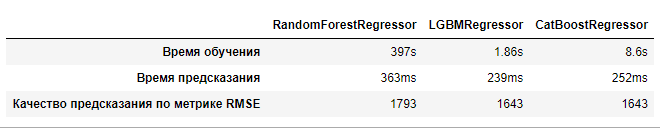



**Лучшая модель LightGBM** на тестовой выборке показала результат по метрике RMSE: 1643